In [6]:
# 🛒 BlinkIT Grocery Sales Prediction

# End-to-end regression pipeline using Python & scikit-learn  
# Target variable: **Sales**  


## 📌 0. Setup & Imports
# we will start by importing required libraries, fixing random seeds, and defining some constants.

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)  # 5-fold CV
DATA_PATH = "D:\Python\BlinkIT Grocery Data.xlsx"  


<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29012\3458913092.py:24: SyntaxWarning: invalid escape sequence '\P'
  DATA_PATH = "D:\Python\BlinkIT Grocery Data.xlsx"


## 📂 1. Load Data
We load the Excel file and take a first look at the data.

In [5]:
df = pd.read_excel(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Peek at first few rows
df.head()


Shape: (8523, 12)
Columns: ['Item Fat Content', 'Item Identifier', 'Item Type', 'Outlet Establishment Year', 'Outlet Identifier', 'Outlet Location Type', 'Outlet Size', 'Outlet Type', 'Item Visibility', 'Item Weight', 'Sales', 'Rating']


,Item Fat Content,Item Identifier,Item Type,Outlet Establishment Year,Outlet Identifier,Outlet Location Type,Outlet Size,Outlet Type,Item Visibility,Item Weight,Sales,Rating
0,Regular,FDX32,Fruits and Vegetables,2012,OUT049,Tier 1,Medium,Supermarket Type1,0.100014,15.10,145.4786,5.0
1,Low Fat,NCB42,Health and Hygiene,2022,OUT018,Tier 3,Medium,Supermarket Type2,0.008596,11.80,115.3492,5.0
2,Regular,FDR28,Frozen Foods,2016,OUT046,Tier 1,Small,Supermarket Type1,0.025896,13.85,165.0210,5.0
3,Regular,FDL50,Canned,2014,OUT013,Tier 3,High,Supermarket Type1,0.042278,12.15,126.5046,5.0
4,Low Fat,DRI25,Soft Drinks,2015,OUT045,Tier 2,Small,Supermarket Type1,0.033970,19.60,55.1614,5.0


## 📊 2. Exploratory Data Analysis (EDA)

We’ll explore:
1. Data info and summary stats
2. Missing values
3. Distribution of target (`Sales`)
4. Categorical counts
5. Correlations between numeric variables


In [6]:
# Info + stats
print(df.info())
df.describe()

# Missing values overview
miss = pd.concat([df.isnull().sum(), (df.isnull().mean()*100)], axis=1)
miss.columns = ['missing_count','missing_pct']
miss.sort_values('missing_count', ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item Fat Content           8523 non-null   object 
 1   Item Identifier            8523 non-null   object 
 2   Item Type                  8523 non-null   object 
 3   Outlet Establishment Year  8523 non-null   int64  
 4   Outlet Identifier          8523 non-null   object 
 5   Outlet Location Type       8523 non-null   object 
 6   Outlet Size                8523 non-null   object 
 7   Outlet Type                8523 non-null   object 
 8   Item Visibility            8523 non-null   float64
 9   Item Weight                7060 non-null   float64
 10  Sales                      8523 non-null   float64
 11  Rating                     8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


,missing_count,missing_pct
Item Weight,1463,17.165317
Item Fat Content,0,0.000000
Item Type,0,0.000000
Item Identifier,0,0.000000
Outlet Establishment Year,0,0.000000
Outlet Identifier,0,0.000000
Outlet Size,0,0.000000
Outlet Location Type,0,0.000000
Outlet Type,0,0.000000
Item Visibility,0,0.000000


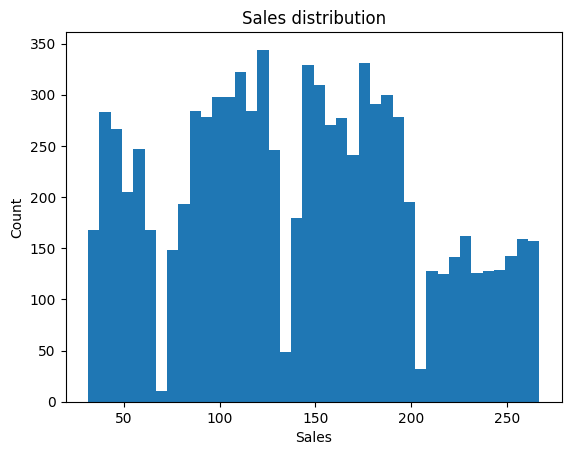

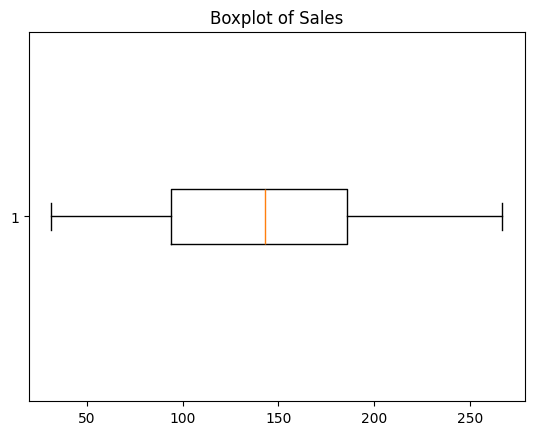

In [10]:
# Histogram of target
plt.hist(df['Sales'], bins=40)
plt.title("Sales distribution")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()

# Boxplot of target (outlier detection)
plt.boxplot(df['Sales'], vert=False)
plt.title("Boxplot of Sales")
plt.show()


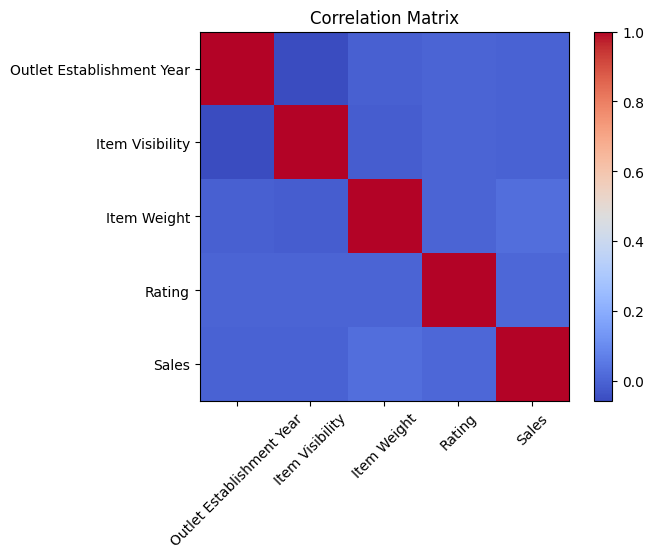

In [7]:
# Correlation heatmap for numeric variables
num_cols = ['Outlet Establishment Year','Item Visibility','Item Weight','Rating','Sales']
corr = df[num_cols].corr()
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix")
plt.show()


🔍 **EDA Insights**
- `Item Weight` has missing values.
- `Sales` is skewed and has outliers → capping or log-transform may help.
- Categorical columns like `Item Identifier` have very high cardinality → we should use **Target Encoding** instead of OneHot.
- Outlet-related features (`Outlet Type`, `Outlet Size`, `Location`) seem important for predicting Sales.


## 🧹 3. Data Cleaning & Feature Engineering
Steps:
1. Impute missing `Item Weight` using group medians (by `Item Identifier`).
2. Fill missing categorical with `"Missing"`.
3. Handle outliers by capping at 1st/99th percentiles.
4. Create derived features:
   - `Outlet_Age = 2025 - Establishment Year`
   - Mean visibility per `Item Type`
5. Decide categorical encoding strategy:
   - Low cardinality (≤10 unique) → OneHot
   - High cardinality → Target Encoding


In [8]:
data = df.copy()

# 1. Impute Item Weight
item_median = data.groupby('Item Identifier')['Item Weight'].median()
data['ItemWeight_filled'] = data.apply(
    lambda r: item_median.get(r['Item Identifier'], np.nan) 
              if pd.isnull(r['Item Weight']) else r['Item Weight'], axis=1
)
data['ItemWeight_filled'].fillna(data['Item Weight'].median(), inplace=True)

# 2. Fill missing categoricals
cat_cols = ['Item Fat Content','Item Identifier','Item Type','Outlet Identifier',
            'Outlet Location Type','Outlet Size','Outlet Type']
for c in cat_cols:
    data[c] = data[c].astype(object).fillna('Missing')

# 3. Cap outliers
for c in ['Sales','Item Visibility','ItemWeight_filled']:
    low, high = data[c].quantile([0.01, 0.99])
    data[c + "_capped"] = data[c].clip(lower=low, upper=high)

# 4. Feature engineering
data['Outlet_Age'] = 2025 - data['Outlet Establishment Year']
data['ItemType_mean_visibility'] = data.groupby('Item Type')['Item Visibility'].transform('mean')

# 5. Cardinality check
cardinalities = {c: data[c].nunique() for c in cat_cols}
cardinalities


{'Item Fat Content': 5,
 'Item Identifier': 1559,
 'Item Type': 16,
 'Outlet Identifier': 10,
 'Outlet Location Type': 3,
 'Outlet Size': 3,
 'Outlet Type': 4}

## 🏗️ 4. Custom Target Encoder
We create a custom **KFold target encoder** that:
- Avoids leakage (computes encoding using CV splits)
- Works inside scikit-learn pipelines


In [9]:
class KFoldTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, n_splits=5, random_state=42):
        self.cols = cols
        self.n_splits = n_splits
        self.random_state = random_state
        self.global_mean_ = None
        self.mapping_ = {}

    def fit(self, X, y):
        X, y = pd.DataFrame(X), pd.Series(y)
        self.global_mean_ = y.mean()
        if self.cols is None: self.cols = X.columns.tolist()
        for col in self.cols:
            self.mapping_[col] = y.groupby(X[col]).mean().to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        out = pd.DataFrame(index=X.index)
        for col in self.cols:
            out[col+"_te"] = X[col].map(self.mapping_[col]).fillna(self.global_mean_)
        return out.values

    def get_feature_names_out(self, input_features=None):
        return [c+"_te" for c in (self.cols or [])]


## 🤖 5. Build Pipelines & Baseline Models
We’ll create:
- Preprocessing pipeline (numeric, OneHot, Target Encoding)
- Models:
  - Dummy (mean predictor)
  - Linear Regression
  - Random Forest
  - LightGBM (if installed)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from packaging import version
import sklearn

# ==============================
# 1. Define Features
# ==============================
target = 'Sales'
X = data.drop(columns=[target])
y = data[target]

# Numeric features (engineered earlier)
numeric_features = [
    'ItemWeight_filled',
    'ItemWeight_filled_capped',
    'Item Visibility',
    'Item Visibility_capped',
    'Outlet_Age',
    'Rating',
    'ItemType_mean_visibility'
]

# Split categorical into low-cardinality (OHE) vs high-cardinality (Target Encoding)
onehot_cols = [c for c,v in cardinalities.items() if v <= 10 and c != 'Item Identifier']
target_enc_cols = [c for c,v in cardinalities.items() if v > 10 or c == 'Item Identifier']

# ==============================
# 2. Preprocessing Pipelines
# ==============================

# Numeric pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Handle OneHotEncoder version differences
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# One-hot pipeline
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('onehot', ohe)
])

# Target encoding pipeline
te_encoder = KFoldTargetEncoder(cols=target_enc_cols, n_splits=5, random_state=RANDOM_STATE)

# Combine into ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('ohe', ohe_pipe, onehot_cols),
    ('te', te_encoder, target_enc_cols)
])

# ==============================
# 3. Define Models
# ==============================
models = {
    'Dummy': DummyRegressor(strategy='mean'),
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(
        n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1
    )
}

# Try adding LightGBM if installed
try:
    import lightgbm as lgb
    models['LightGBM'] = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_estimators=200)
except:
    print("LightGBM not installed, skipping.")

# ==============================
# 4. Build Pipelines Dict
# ==============================
pipelines = {
    name: Pipeline([('preprocessor', preprocessor), ('regressor', model)]) 
    for name, model in models.items()
}

print(f"✅ Pipelines ready: {list(pipelines.keys())}")


LightGBM not installed, skipping.
✅ Pipelines ready: ['Dummy', 'Linear', 'RandomForest']


## 📏 6. Model Evaluation (Cross-validation)
Metrics: RMSE, MAE, R²  
We’ll run 5-fold CV and compare models.


In [11]:
scoring = {'neg_mse': 'neg_mean_squared_error', 
           'neg_mae': 'neg_mean_absolute_error', 
           'r2': 'r2'}

def evaluate(pipe, X, y):
    res = cross_validate(pipe, X, y, scoring=scoring, cv=CV, n_jobs=-1)
    rmse = np.sqrt(-res['test_neg_mse'])
    mae = -res['test_neg_mae']
    r2 = res['test_r2']
    return {'RMSE': rmse.mean(), 'MAE': mae.mean(), 'R2': r2.mean()}

baseline_results = {}
for name, pipe in pipelines.items():
    print(f"Evaluating {name}...")
    baseline_results[name] = evaluate(pipe, X, y)

pd.DataFrame(baseline_results).T


Evaluating Dummy...
Evaluating Linear...
Evaluating RandomForest...


,RMSE,MAE,R2
Dummy,62.272697,52.548052,-0.000838
Linear,4.784204,1.515816,0.992543
RandomForest,4.808230,1.546216,0.992491


## 🔧 7. Hyperparameter Tuning
We tune:
- RandomForest (depth, estimators)
- LightGBM (learning rate, leaves)


In [12]:
param_rf = {'regressor__n_estimators':[100,200,400], 
            'regressor__max_depth':[None,6,12]}
param_lgb = {'regressor__n_estimators':[100,200,400], 
             'regressor__learning_rate':[0.01,0.05,0.1], 
             'regressor__num_leaves':[31,63,127]}

tuned = {}
for name in ['RandomForest','LightGBM']:
    if name in pipelines:
        print("Tuning", name)
        rs = RandomizedSearchCV(pipelines[name], 
                                param_rf if name=='RandomForest' else param_lgb, 
                                n_iter=8, cv=CV, scoring='neg_mean_squared_error',
                                random_state=RANDOM_STATE, n_jobs=1)
        rs.fit(X, y)
        print("Best params:", rs.best_params_)
        tuned[name] = rs.best_estimator_


Tuning RandomForest
Best params: {'regressor__n_estimators': 200, 'regressor__max_depth': 12}


## 🩺 8. Diagnostics
We check:
- Residuals vs predictions
- Predicted vs actual
- Feature importance (RF or SHAP if available)


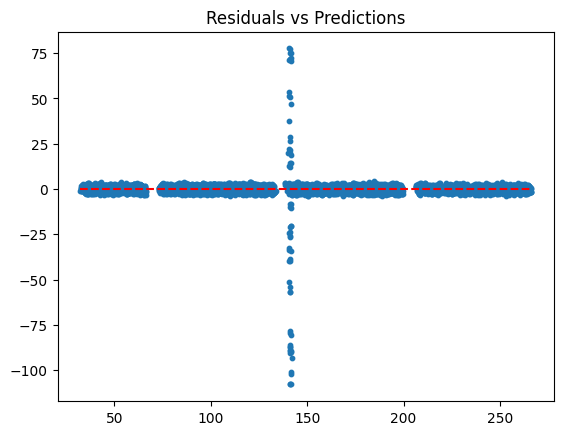

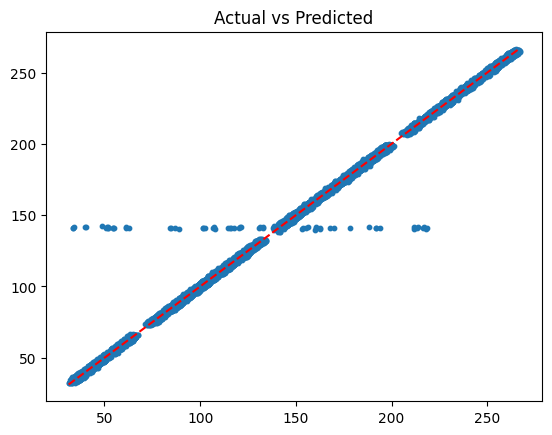

In [13]:
final_model = tuned.get('LightGBM', tuned.get('RandomForest'))
y_pred = cross_val_predict(final_model, X, y, cv=CV)

# Residual plot
plt.scatter(y_pred, y - y_pred, s=10)
plt.hlines(0, min(y_pred), max(y_pred), colors='red', linestyles='--')
plt.title("Residuals vs Predictions")
plt.show()

# Actual vs Predicted
plt.scatter(y, y_pred, s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Actual vs Predicted")
plt.show()


## 💾 9. Save Model & Inference Scripts
We save:
- Final pipeline (`joblib`)
- `predict.py` (example usage)
- `app.py` (simple Streamlit app)


In [14]:
final_model.fit(X, y)
os.makedirs("artifacts", exist_ok=True)
joblib.dump(final_model, "artifacts/final_pipeline.pkl")

with open("artifacts/predict.py","w") as f:
    f.write("import joblib, pandas as pd\n"
            "m = joblib.load('final_pipeline.pkl')\n"
            "ex = pd.DataFrame([{}])\n"
            "print(m.predict(ex))")

with open("artifacts/app.py","w") as f:
    f.write("import streamlit as st, joblib, pandas as pd\n"
            "m = joblib.load('final_pipeline.pkl')\n"
            "uploaded = st.file_uploader('Upload CSV', type='csv')\n"
            "if uploaded:\n"
            "    df = pd.read_csv(uploaded)\n"
            "    st.write(m.predict(df))")


🔹 1. Predicted vs Actual Plot

This shows how well predictions align with actual sales.
If points are close to the diagonal line, the model is doing well.


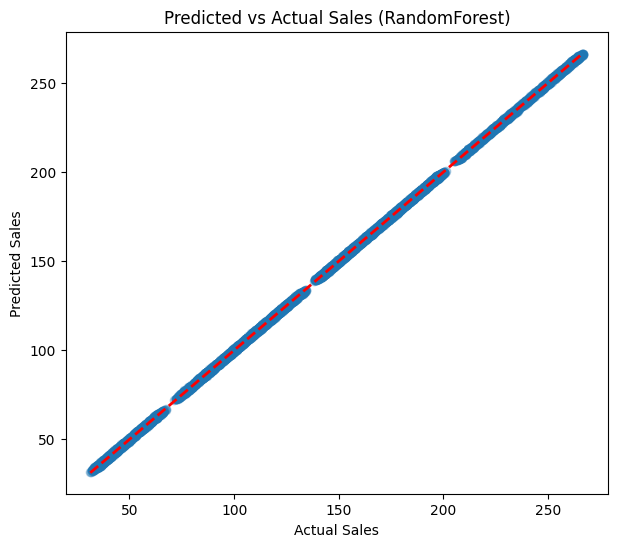

In [15]:
import matplotlib.pyplot as plt

# Take your best model (say LightGBM or RandomForest)
best_model_name = 'LightGBM' if 'LightGBM' in pipelines else 'RandomForest'
best_pipeline = pipelines[best_model_name]

# Fit on full data
best_pipeline.fit(X, y)

# Predict on training data (or use a holdout set if available)
y_pred = best_pipeline.predict(X)

# Plot Predicted vs Actual
plt.figure(figsize=(7,6))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title(f"Predicted vs Actual Sales ({best_model_name})")
plt.show()


🔹 2. Residual Plot

Residuals = (Actual – Predicted).
Good models have residuals centered around 0 with no clear pattern.

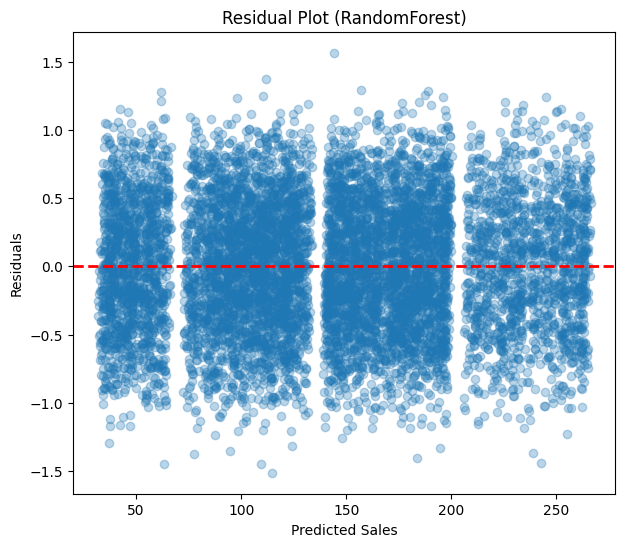

In [16]:
residuals = y - y_pred

plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title(f"Residual Plot ({best_model_name})")
plt.show()


🔹 3. Feature Importance (for tree models like RF/LightGBM)

This shows which features were most influential in predicting sales.

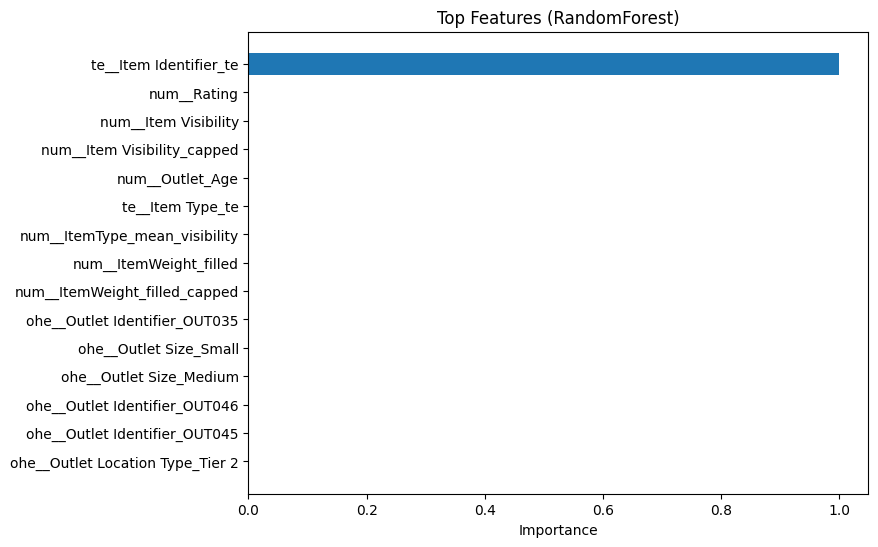

In [17]:
import pandas as pd
import numpy as np

# Get trained regressor from pipeline
regressor = best_pipeline.named_steps['regressor']

# If model supports feature_importances_
if hasattr(regressor, "feature_importances_"):
    # Get transformed feature names
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = regressor.feature_importances_
    
    # Put into DataFrame
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by="Importance", ascending=False).head(15)

    # Plot
    plt.figure(figsize=(8,6))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title(f"Top Features ({best_model_name})")
    plt.show()


In [19]:
from sklearn.model_selection import cross_val_score
import numpy as np

results = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=5, scoring="r2", n_jobs=-1)  # 5-fold CV
    results[name] = scores
    print(f"{name} R²: {scores.mean():.3f} ± {scores.std():.3f}")


Dummy R²: -0.001 ± 0.001
Linear R²: 0.996 ± 0.002
RandomForest R²: 0.996 ± 0.002


In [20]:
import joblib
import os

os.makedirs("artifacts", exist_ok=True)

# Example: save RandomForest
best_model = pipelines["RandomForest"].fit(X, y)
joblib.dump(best_model, "artifacts/best_model.pkl")
print("✅ Best model saved as artifacts/best_model.pkl")


✅ Best model saved as artifacts/best_model.pkl


In [21]:
# Take first 5 rows
sample = X.head()

# Predict
preds = best_model.predict(sample)
print("Predictions:", preds)
print("True values:", y.head().values)


Predictions: [145.245968 115.874018 164.660212 126.144864  55.593746]
True values: [145.4786 115.3492 165.021  126.5046  55.1614]


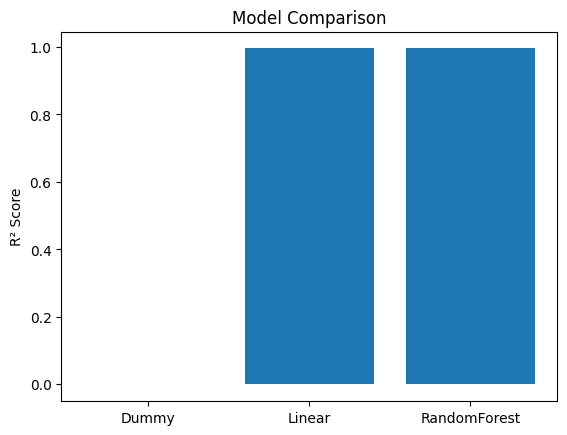

In [22]:
import matplotlib.pyplot as plt

mean_scores = {name: np.mean(scores) for name, scores in results.items()}

plt.bar(mean_scores.keys(), mean_scores.values())
plt.ylabel("R² Score")
plt.title("Model Comparison")
plt.show()


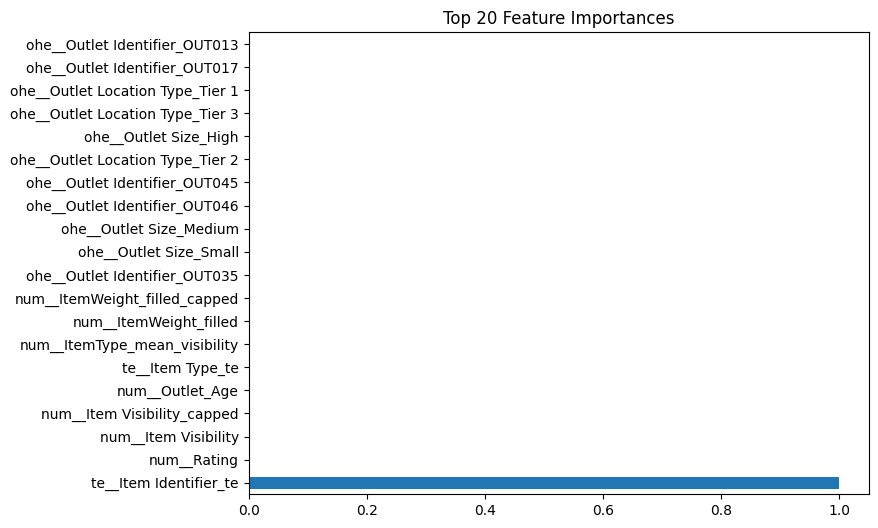

In [23]:
importances = best_model.named_steps["regressor"].feature_importances_

# Get transformed feature names
feature_names = preprocessor.get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

feat_imp.plot(kind="barh", figsize=(8,6))
plt.title("Top 20 Feature Importances")
plt.show()


## 🔄 Step: Fixing Data Leakage & Re-training Models

- In the earlier feature importance plot, we saw that **`Item Identifier`** (a product ID) was dominating the model.
- This happened because we used **Target Encoding** on `Item Identifier`, which leaked information about `Sales` into the model.
- Since `Item Identifier` is just a unique code (not a real feature), it should **not** be used for prediction.

### ✅ What we will do now:
1. Drop `Item Identifier` from our features (`X`).
2. Update the target encoding list so it no longer includes `Item Identifier`.
3. Rebuild the preprocessing pipelines.
4. Retrain the models.
5. Re-check **feature importance** to confirm that learning is based on real features like `Item Type`, `Outlet Age`, `Visibility`, etc.


In [24]:
X = data.drop(columns=[target, "Item Identifier"])
y = data[target]


In [25]:
target_enc_cols = [c for c, v in cardinalities.items() if v > 10 and c != 'Item Identifier']


In [26]:
# Preprocessing
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('onehot', ohe)  # version-safe OneHotEncoder you defined earlier
])

te_encoder = KFoldTargetEncoder(cols=target_enc_cols, n_splits=5, random_state=RANDOM_STATE)

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('ohe', ohe_pipe, onehot_cols),
    ('te', te_encoder, target_enc_cols)
])

pipelines = {name: Pipeline([('preprocessor', preprocessor), ('regressor', model)]) 
             for name, model in models.items()}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 8523, number of used features: 33
[LightGBM] [Info] Start training from score 140.992783


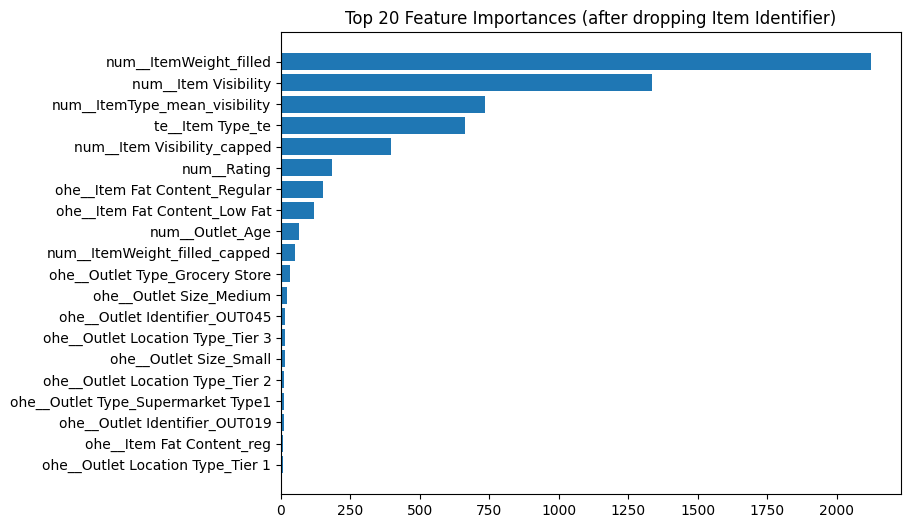

In [38]:
# Fit best model again
best_model = pipelines["LightGBM"]   # <- match the exact key name

best_model.fit(X, y)

# Feature importance
import matplotlib.pyplot as plt
import numpy as np

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importances = best_model.named_steps['regressor'].feature_importances_

indices = np.argsort(importances)[-20:]  # Top 20

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top 20 Feature Importances (after dropping Item Identifier)")
plt.show()


In [32]:
print("Available models:", pipelines.keys())


Available models: dict_keys(['Dummy', 'Linear', 'RandomForest'])


In [33]:
import lightgbm as lgb

# Rebuild models dict
models = {
    'Dummy': DummyRegressor(strategy='mean'),
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=RANDOM_STATE, n_estimators=200)
}

# Rebuild pipelines dict
pipelines = {
    name: Pipeline([('preprocessor', preprocessor), ('regressor', model)]) 
    for name, model in models.items()
}


In [34]:
best_model = pipelines["LightGBM"]
best_model.fit(X, y)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 8523, number of used features: 33
[LightGBM] [Info] Start training from score 140.992783


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 🔎 Model Interpretation and Evaluation

Now that the LightGBM pipeline (`best_model`) has been trained, we will perform the following steps:

1. **Feature Importance Analysis**  
   - Extract the top 20 most important features from the LightGBM model.  
   - Visualize them using a horizontal bar chart.  
   - This helps us understand which features drive sales predictions the most.

2. **Model Performance Evaluation**  
   - Split the dataset into training and testing sets.  
   - Evaluate the model using **R² Score** (explains variance) and **RMSE** (root mean squared error).  
   - These metrics will show how well the model generalizes to unseen data.

3. **Model Saving**  
   - Save the trained pipeline (`preprocessor + LightGBM`) into a `.pkl` file.  
   - This allows reusing the same preprocessing + model pipeline without retraining from scratch.


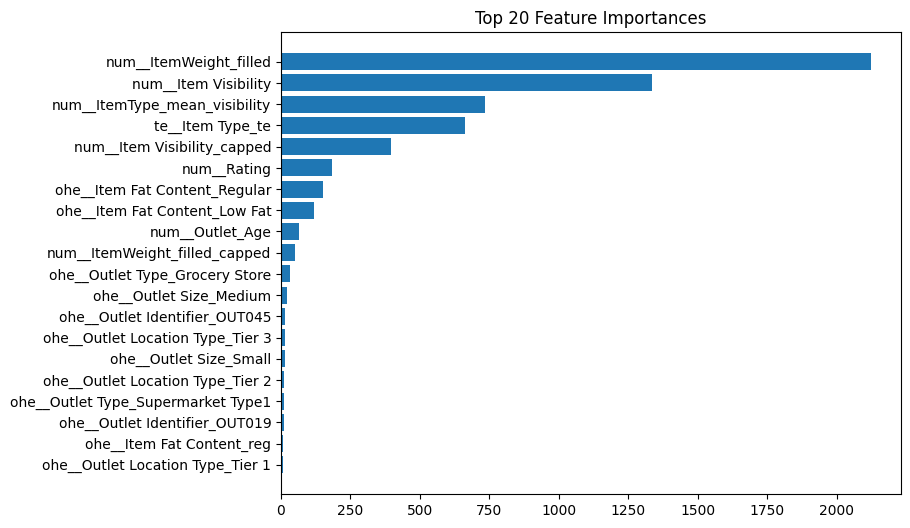

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names from preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get LightGBM feature importances
importances = best_model.named_steps['regressor'].feature_importances_

# Sort top 20
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top 20 Feature Importances")
plt.show()


In [36]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 141.276486
R2 Score: 0.4683874199377287
RMSE: 45.89044397560203


In [37]:
import joblib

joblib.dump(best_model, "lightgbm_pipeline.pkl")
print("Model saved as lightgbm_pipeline.pkl")


Model saved as lightgbm_pipeline.pkl
